# Self exciting volatility

In this notebook we'll consider modelling the returns of [ENEL](https://www.enel.com/) utilizing a _self-exciting process_ TODO: model it. We begin by importing the necessary data

<AxesSubplot:xlabel='Date'>

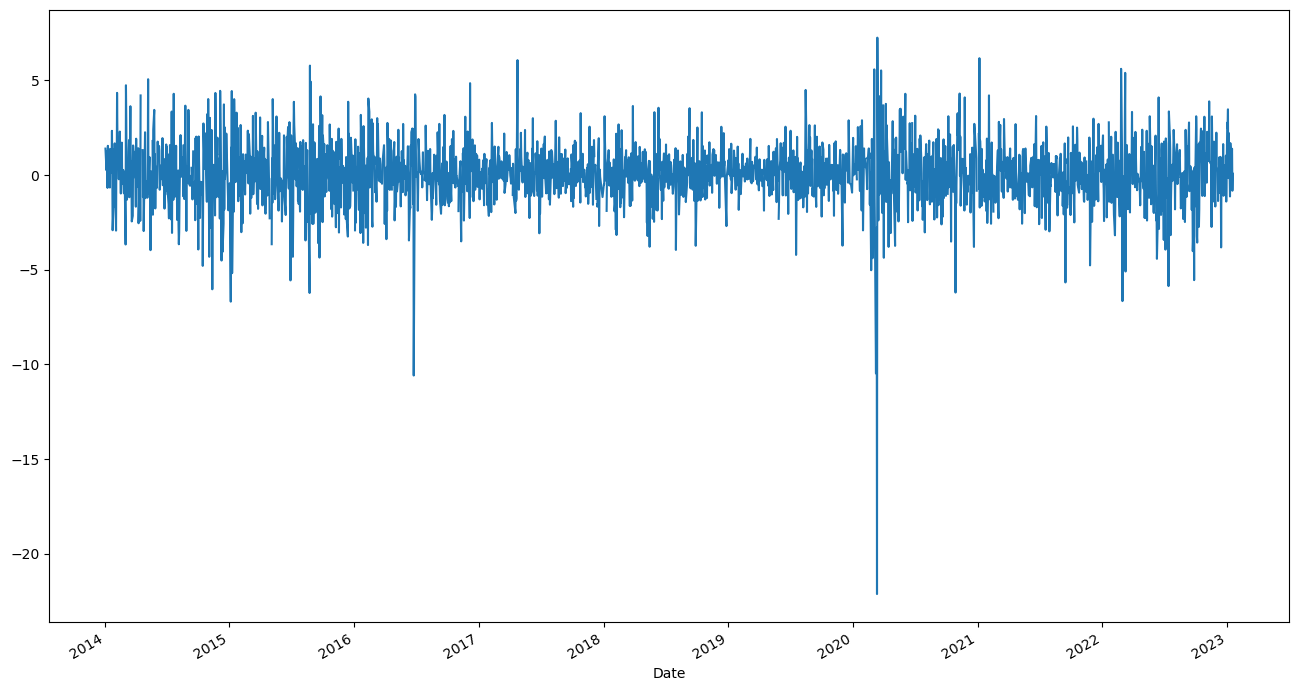

In [1]:
from yfinance import Ticker
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

equity = Ticker("ENEL.MI")
history = equity.history(start="2014-01-01")

log_returns = np.log(history["Close"]).diff().iloc[1:] * 100.0

log_returns.where(log_returns != 0.0, np.nan, inplace=True)
log_returns.plot()

Next up, we'll perform the actual modelling. We import the model from [stoch-proc](https://github.com/tingiskhan/stoch-proc) and define the state space model

In [2]:
from sre_parse import State
from stochproc.timeseries import StateSpaceModel, models
from stochproc.distributions import NegativeExponential
from pyfilter.inference import InferenceContext
from pyro.distributions import Exponential, LogNormal, Uniform, Normal, TransformedDistribution, transforms
import torch
from functools import partial


def build_observation(x, mu, dist):
    dN_t = x.value[..., 1]

    lambda_s = x.value[..., 2]
    q = x.value[..., 3]

    loc = mu # + lambda_s * dist.phi_fun - q * dN_t
    print(x.value[..., 0])
    return Normal(loc, x.value[..., 0])


def model(context: InferenceContext):
    # Volatility
    alpha = context.named_parameter("alpha", Exponential(10.0).cuda())
    xi = context.named_parameter("xi", LogNormal(1.0, 0.5).cuda())
    eta = context.named_parameter("eta", LogNormal(-2.0, 1.0).cuda())

    rho = context.named_parameter("rho", Uniform(0.0, 1.0).cuda())

    rho_minus_prior = TransformedDistribution(Exponential(5.0).cuda(), transforms.AffineTransform(0.0, -1.0))    
    rho_minus = context.named_parameter("rho_minus", rho_minus_prior)
    rho_plus = context.named_parameter("rho_plus", Exponential(5.0).cuda())
    
    dt = 0.2
    volatility = models.SelfExcitingLatentProcesses(alpha, xi, eta, rho, rho_minus, rho_plus, dt=dt)

    # Observable
    mu = context.named_parameter("mu", Normal(0.0, 0.5).cuda())
    f = partial(build_observation, dist=volatility.de)

    return StateSpaceModel(volatility, f, (mu,), observe_every_step=int(1.0 / dt))

Next, we'll try to infer the parameters of the model

In [3]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters.particle import SISR
from pyfilter import inference

y = torch.from_numpy(log_returns.values).float().cuda()

with inference.make_context(use_quasi=True) as context:
    filt = SISR(model, 1_000)
    alg = SMC2(filt, 2_000, num_steps=10, distance_threshold=0.025)

    state = alg.fit(y)

SMC2:   0%|          | 2/2300 [00:00<02:48, 13.62it/s]

tensor([109.3601,  15.6961, 157.7087,  ...,   8.3977,  12.4338, 144.0124],
       device='cuda:0')
tensor([[  9.2321, 236.3351,   5.2200,  ...,  92.6897,  11.6010,  18.9200],
        [188.3575, 112.4260,   3.8851,  ..., 122.7127,  24.4374,  73.0545],
        [108.7673, 241.5594,  12.3907,  ...,  30.0908,   7.6040,  10.1015],
        ...,
        [158.3042, 105.4246,   6.8933,  ...,  62.9693,   7.7298,  17.0022],
        [122.6483, 131.8162,   3.1426,  ...,  81.2138,  11.1725,  13.1316],
        [ 37.1487, 119.6546,  11.7356,  ...,  15.3224,  27.6597,  44.1611]],
       device='cuda:0')
tensor([[  9.4086, 114.5508,  18.6760,  ..., 139.3117,  14.9784,  20.1723],
        [ 11.5113,  20.3106,  21.1819,  ...,  28.5112,  11.6737,  12.4087],
        [102.4051,  14.7359,  16.2784,  ...,  25.2566,  10.3594,  21.5579],
        ...,
        [  2.0610,  88.2270,  16.9089,  ...,  24.4189,   0.5598,  59.8429],
        [103.5505,  57.3224,  12.5441,  ...,  97.2004,   8.5287,  15.6976],
        [ 37.9

/opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/cuda/DistributionTemplates.h:598: operator(): block: [139,0,0], thread: [268,0,0] Assertion `0 <= p3 && p3 <= 1` failed.
SMC2:   0%|          | 3/2300 [00:01<12:48,  2.99it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.